In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import dask
import scipy
import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import netCDF4 as nc
from netCDF4 import Dataset
import geopandas as gpd
import os
import skimage

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as mpatches

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.img_tiles import Stamen
from cartopy.io.img_tiles import MapboxTiles
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings("ignore")

import imageio
import geojson
import requests

from launches import *
from utils import *

from scipy.optimize import curve_fit
import matplotlib as mpl
from matplotlib import font_manager as fm

%matplotlib inline

In [9]:
# 1) Register your new fonts explicitly
font_dir = os.path.expanduser("~/.local/share/fonts")
for path in glob.glob(os.path.join(font_dir, "lm*.otf")):
    fm.fontManager.addfont(path)
for path in glob.glob(os.path.join(font_dir, "cmu*.otf")):
    fm.fontManager.addfont(path)
# Global LaTeX-y defaults
mpl.rcParams.update({
    "text.usetex": False,              # keep mathtext (no TeX required)
    "mathtext.fontset": "cm",          # Computer Modern math
    "axes.unicode_minus": False,

    # Default family = serif (like LaTeX)
    "font.family": "serif",

    # Families mapped to your installed fonts (with sensible fallbacks)
    "font.serif": ["LMRoman10", "CMU Serif", "DejaVu Serif"],
    "font.sans-serif": ["LMSans10", "CMU Sans Serif", "DejaVu Sans"],
    "font.monospace": ["LMMono10", "CMU Typewriter Text", "DejaVu Sans Mono"],
})


### Load Data

In [10]:
detections_df = pd.read_csv('data/detections_final.csv',)
detections_df['timestamp'] = pd.to_datetime(detections_df['Launch_JD'], unit='D', origin='julian')

# Plume Processing

In [11]:
# multi_detections_df['time_delta_min'] = multi_detections_df['L2_time_delta'].astype('timedelta64[ns]').dt.total_seconds() / 60
falcon_9 = detections_df[detections_df['LV_Type'] == 'Falcon 9']
falcon_9 = falcon_9[falcon_9['ime']<4000]
tmp = falcon_9[(falcon_9['ime'] < 10000)]
tmp = tmp[tmp['time_delta_min'] < 1000]
# Ensure timezone-aware UTC
tmp['timestamp'] = pd.to_datetime(tmp['timestamp'], utc=True)

# Define exponential decay model
def exp_decay(t, A, k):
    return A * np.exp(-k * t)

tmp = tmp[tmp['time_delta_min'] > 0.5]
# print(tmp[(tmp['enhancement_molno2']/1000) > 26])
tmp = tmp[(tmp['enhancement_molno2']/1000) < 26]
# remove index 56
# print(tmp.loc[56])
# print(tmp.loc[47])
# tmp = tmp[tmp.index != 56]
# tmp = tmp[tmp.index != 47]

# Fit model to data
time_values = tmp['time_delta_min'].values / 60
no2_values = tmp['enhancement_molno2'].values
valid = no2_values > 0  # avoid zeros for fitting
popt, pcov = curve_fit(exp_decay, time_values[valid], no2_values[valid], p0=(20000, 0.01))

A_fit, k_fit = popt
perr = np.sqrt(np.diag(pcov))  # standard deviation (1σ uncertainty) of each parameter
A_err, k_err = perr

# Predict NO₂ using the fitted curve
t_fit = np.linspace(0, time_values.max(), 200)
print(f"Fitted parameters: A = {A_fit}, k = {k_fit}")
no2_fit = exp_decay(t_fit, A_fit, k_fit)

# Sample parameters from the multivariate normal
samples = np.random.multivariate_normal(popt, pcov, size=1000)

# Evaluate model for each sample
y_samples = np.array([exp_decay(t_fit, *params) for params in samples])

# Get percentiles for confidence interval
y_lower = np.percentile(y_samples, 2.5, axis=0)/1000
y_upper = np.percentile(y_samples, 97.5, axis=0)/1000

Fitted parameters: A = 13554.012467583758, k = 0.424470886399612


# Figure S5

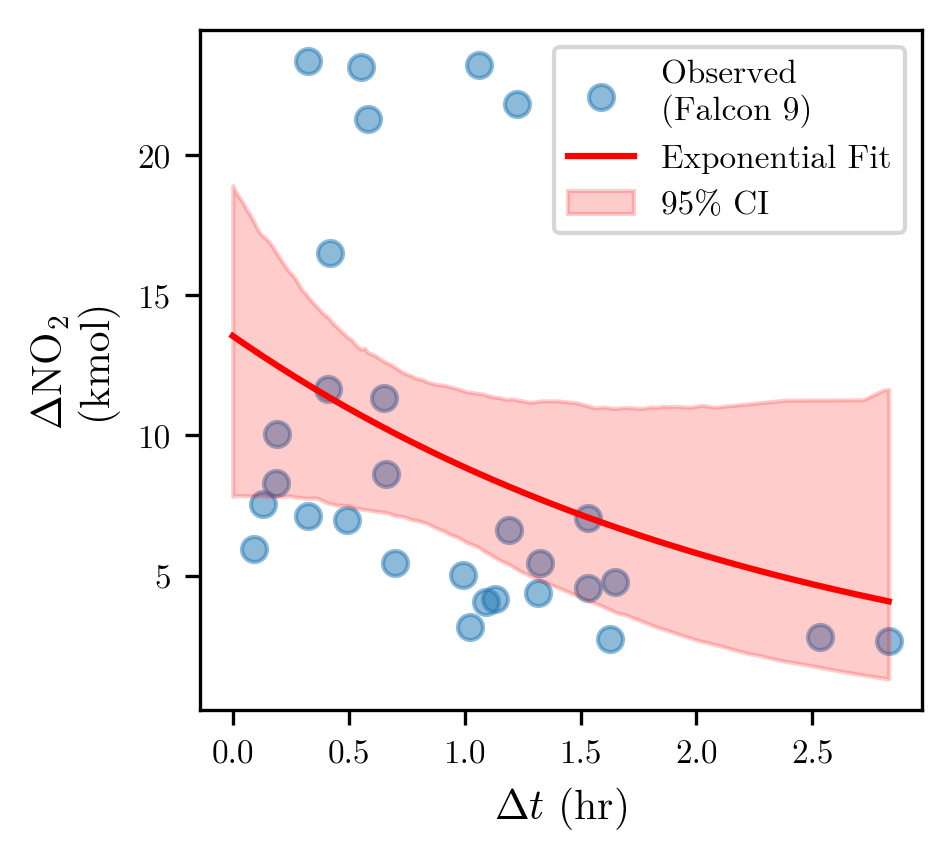

In [12]:
# Plot original data and fitted curve
fig, ax = plt.subplots(figsize=(3.3, 3), dpi=300)
plt.scatter(time_values, no2_values/1000, alpha=0.5, label='Observed  \n(Falcon 9)', vmin=20, vmax=70)
# plt.scatter(time_values, no2_values/1000, alpha=0.5, c=sza_values, label='Observed', vmin=20, vmax=70)
plt.plot(t_fit, no2_fit/1000, color='red', label=f'Exponential Fit')#:\nNO₂ = {A_fit:.1e}·exp(-{k_fit:.3f}·t)')
# Plot confidence interval
plt.fill_between(t_fit, y_lower, y_upper, color='red', alpha=0.2, label='95% CI')   
plt.xlabel('$\Delta t$ (hr)')
plt.ylabel('$\Delta$NO$_2$ \n (kmol)')
plt.legend(fontsize=8,)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.colorbar(label='SZA (degrees)')
# save figure
plt.savefig(f'figures/supfig_5.png', dpi=300)
plt.show()

#### Lifetime and 95% CI

In [13]:
k_hat = k_fit
tau_hat = 1.0 / k_hat

k_se = np.sqrt(pcov[1,1])
tau_se = k_se / (k_hat**2)

ci_tau_delta = (tau_hat - 1.96*tau_se, tau_hat + 1.96*tau_se)
print(f"tau (hours) = {tau_hat:.2f}  [delta 95% CI: {ci_tau_delta[0]:.2f}, {ci_tau_delta[1]:.2f}]")

tau (hours) = 2.36  [delta 95% CI: -0.32, 5.03]
